### 1. Pobranie zbioru cifar i wyświetlenie kilku obrazów

Files already downloaded and verified


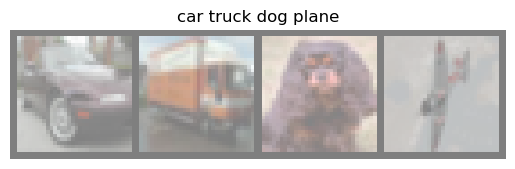

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

def imshow(img, labels):
    img = img / 2 + 0.5  # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    label_text = ' '.join(classes[labels[j]] for j in range(len(labels)))
    plt.title(label_text)
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images), labels)

### 3. Stworzenie sieci neuronowej podobnej do LeNet-5

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5CIFAR10(nn.Module):
    def __init__(self):
        super(LeNet5CIFAR10, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Layer 1: Convolution -> ReLU -> Avg Pooling
        x = F.relu(self.conv1(x))          # Conv1
        x = F.avg_pool2d(x, 2)             # 2x2 Avg Pooling
        
        # Layer 2: Convolution -> ReLU -> Avg Pooling
        x = F.relu(self.conv2(x))          # Conv2
        x = F.avg_pool2d(x, 2)             # 2x2 Avg Pooling
        
        # Flatten the output for fully connected layers
        x = x.view(-1, 16 * 5 * 5)
        
        # Fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Output layer (before softmax)
        x = self.fc3(x)
        
        # Apply softmax for class probabilities
        return F.softmax(x, dim=1)

net = LeNet5CIFAR10()

print(net)

params = 0
for parameter in net.parameters(): 
    subsum=1
    for el in parameter.size():
        subsum*=el
    params+=subsum
    
print(params)



LeNet5CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
62006
